<a href="https://www.kaggle.com/code/afifaniks/footpath-semantic-segmentation?scriptVersionId=97198855" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Footpath Segmentatioon using Semantic Segmentation (UNET)
Author: [Afif Al Mamun](https://afifaniks.github.io) <br>
Date: November 24, 2019 <br>
Update (TF 2+ support): June 2022

# Let's Include the Essentials

In [1]:
!pip install keras_unet

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras.layers import Flatten

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
im_width = 256
im_height = 256

In [4]:
root = "../input/footpath-image-dataset"
image_path = os.path.join(root, "images")
mask_path = os.path.join(root, "masks")

In [5]:
ids = next(os.walk(image_path))[2]
print(f"Total images: {len(ids)}")

Total images: 3000


# Data Preparation

In [6]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [7]:
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    img = load_img(image_path + "/" + id_, color_mode="grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    
    mask = img_to_array(load_img(mask_path + "/" + id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    
    X[n] = x_img/255.0
    y[n] = mask/255.0

  0%|          | 0/3000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Observation from the Prepared Dataset

Text(0.5, 1.0, 'Footpath')

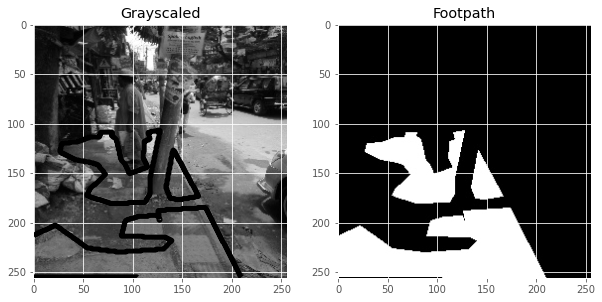

In [9]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Footpath indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))


ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating footpath and non-footpath areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Grayscaled')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Footpath')

# Preparing the Network

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

     # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, k_size=3):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Let the Train Begin

In [12]:
input_img = Input((im_height, im_width, 1), name="img")
model = get_unet(input_img, n_filters=32, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, iou_thresholded, dice_coef])

2022-06-01 11:32:10.328507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 11:32:10.455667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 11:32:10.456601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 11:32:10.457863: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 256, 256, 32) 128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 256, 256, 32) 0           batch_normalization_3[0][0]      
______________________________________________________________________________________________

In [14]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('footpath.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
batch_size = 15

In [16]:
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=40, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

2022-06-01 11:32:14.048361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 629145600 exceeds 10% of free system memory.
2022-06-01 11:32:14.698683: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 629145600 exceeds 10% of free system memory.
2022-06-01 11:32:15.395407: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 629145600 exceeds 10% of free system memory.
2022-06-01 11:32:15.878693: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 629145600 exceeds 10% of free system memory.
2022-06-01 11:32:16.387302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-06-01 11:32:19.376694: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 [==============================] - 34s 153ms/step - loss: 0.2799 - accuracy: 0.8688 - iou: 0.5655 - iou_thresholded: 0.6959 - dice_coef: 0.7187 - val_loss: 1.4667 - val_accuracy: 0.5853 - val_iou: 0.2634 - val_iou_thresholded: 0.2646 - val_dice_coef: 0.4163

Epoch 00001: val_loss improved from inf to 1.46674, saving model to footpath.h5
Epoch 2/40
160/160 [==============================] - 23s 146ms/step - loss: 0.2020 - accuracy: 0.9017 - iou: 0.6561 - iou_thresholded: 0.7581 - dice_coef: 0.7914 - val_loss: 0.8511 - val_accuracy: 0.7111 - val_iou: 0.3255 - val_iou_thresholded: 0.3253 - val_dice_coef: 0.4902

Epoch 00002: val_loss improved from 1.46674 to 0.85111, saving model to footpath.h5
Epoch 3/40
160/160 [==============================] - 23s 146ms/step - loss: 0.1812 - accuracy: 0.9098 - iou: 0.6882 - iou_thresholded: 0.7799 - dice_coef: 0.8146 - val_loss: 0.1812 - val_accuracy: 0.9111 - val_iou: 0.7262 - val_iou_thresholded: 0.7822 - val_dice_coef: 0.8405

Epoch 00003: 

# Picking up the Best Model

In [17]:
best_model = np.argmin(results.history["val_loss"])

# Digging into Training

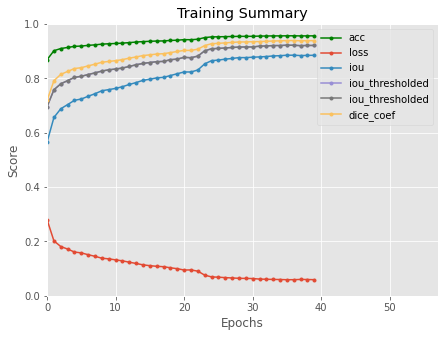

In [18]:
plt.figure(figsize=(7, 5))
plt.title("Training Summary")
plt.xlim(0, 57)
plt.ylim(0, 1)
plt.plot(results.history["accuracy"], label="acc", color='g', marker = '.')
plt.plot(results.history["loss"], label="loss", marker = '.')
plt.plot(results.history["iou"], label="iou", marker = '.')
plt.plot(results.history["iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["iou_thresholded"], label="iou_thresholded", marker = '.')
plt.plot(results.history["dice_coef"], label="dice_coef", marker = '.')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend();

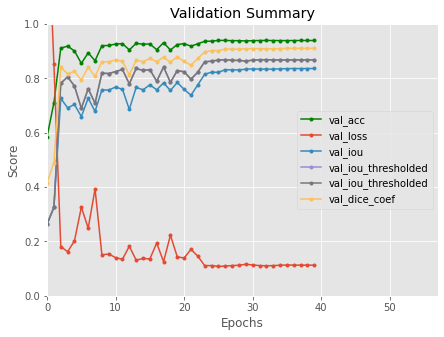

In [19]:
plt.figure(figsize=(7, 5))
plt.title("Validation Summary")
plt.xlim(0, 57)
plt.ylim(0, 1)
plt.plot(results.history["val_accuracy"], label="val_acc", color='g', marker = '.')
plt.plot(results.history["val_loss"], label="val_loss", marker = '.')
plt.plot(results.history["val_iou"], label="val_iou", marker = '.')
plt.plot(results.history["val_iou_thresholded"], label="val_iou_thresholded", marker = '.')
plt.plot(results.history["val_iou_thresholded"], label="val_iou_thresholded", marker = '.')
plt.plot(results.history["val_dice_coef"], label="val_dice_coef", marker = '.')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend();

# Evaluation of the Trained Model

In [20]:
model.load_weights('footpath.h5')

In [21]:
model.evaluate(X_valid, y_valid, verbose=1)

19/19 [==============================] - 3s 110ms/step - loss: 0.1081 - accuracy: 0.9395 - iou: 0.8216 - iou_thresholded: 0.8669 - dice_coef: 0.9018


[0.10810376703739166,
 0.9395469427108765,
 0.8215844631195068,
 0.8669214844703674,
 0.901777982711792]

In [22]:
# Predict on train, and val
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2022-06-01 11:48:56.460992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 629145600 exceeds 10% of free system memory.


19/19 [==============================] - 2s 73ms/step


In [23]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [24]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Grayscaled')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Footpath')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Footpath Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Footpath Predicted binary');

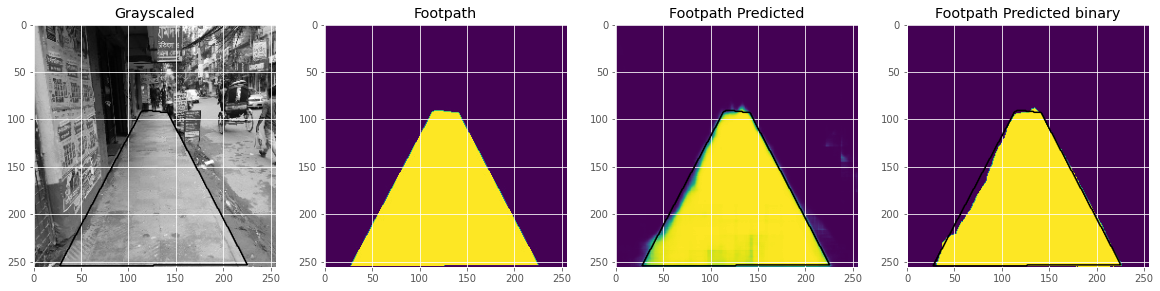

In [25]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

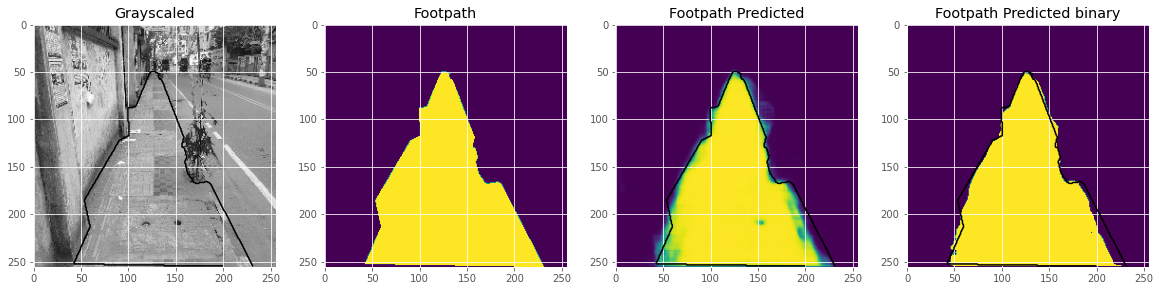

In [26]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

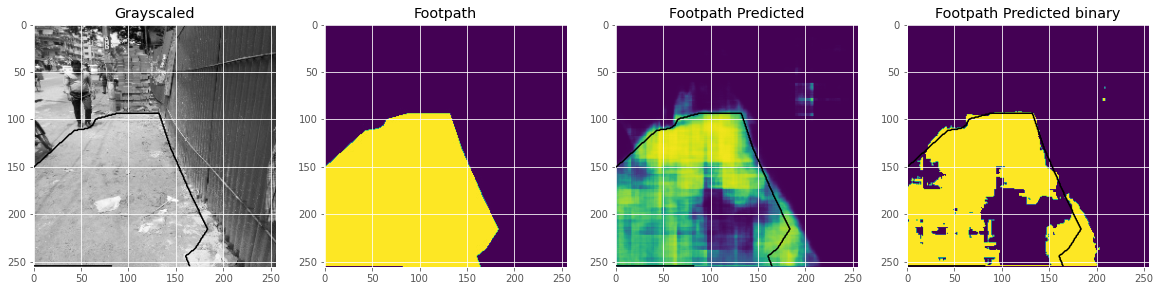

In [27]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

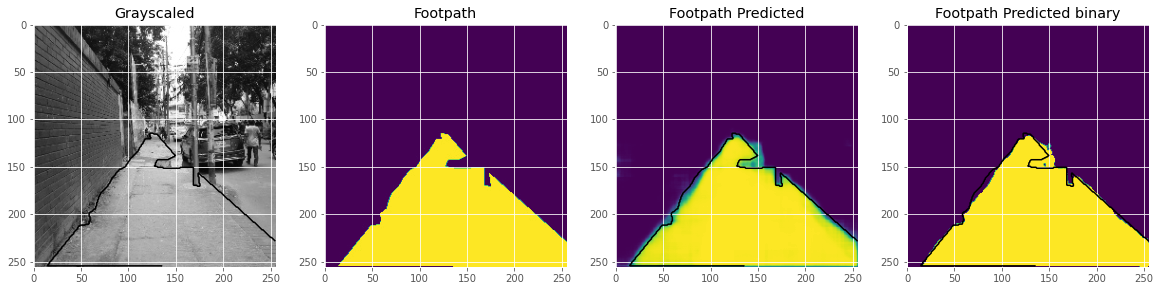

In [28]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

# Intermediate Layer Outputs

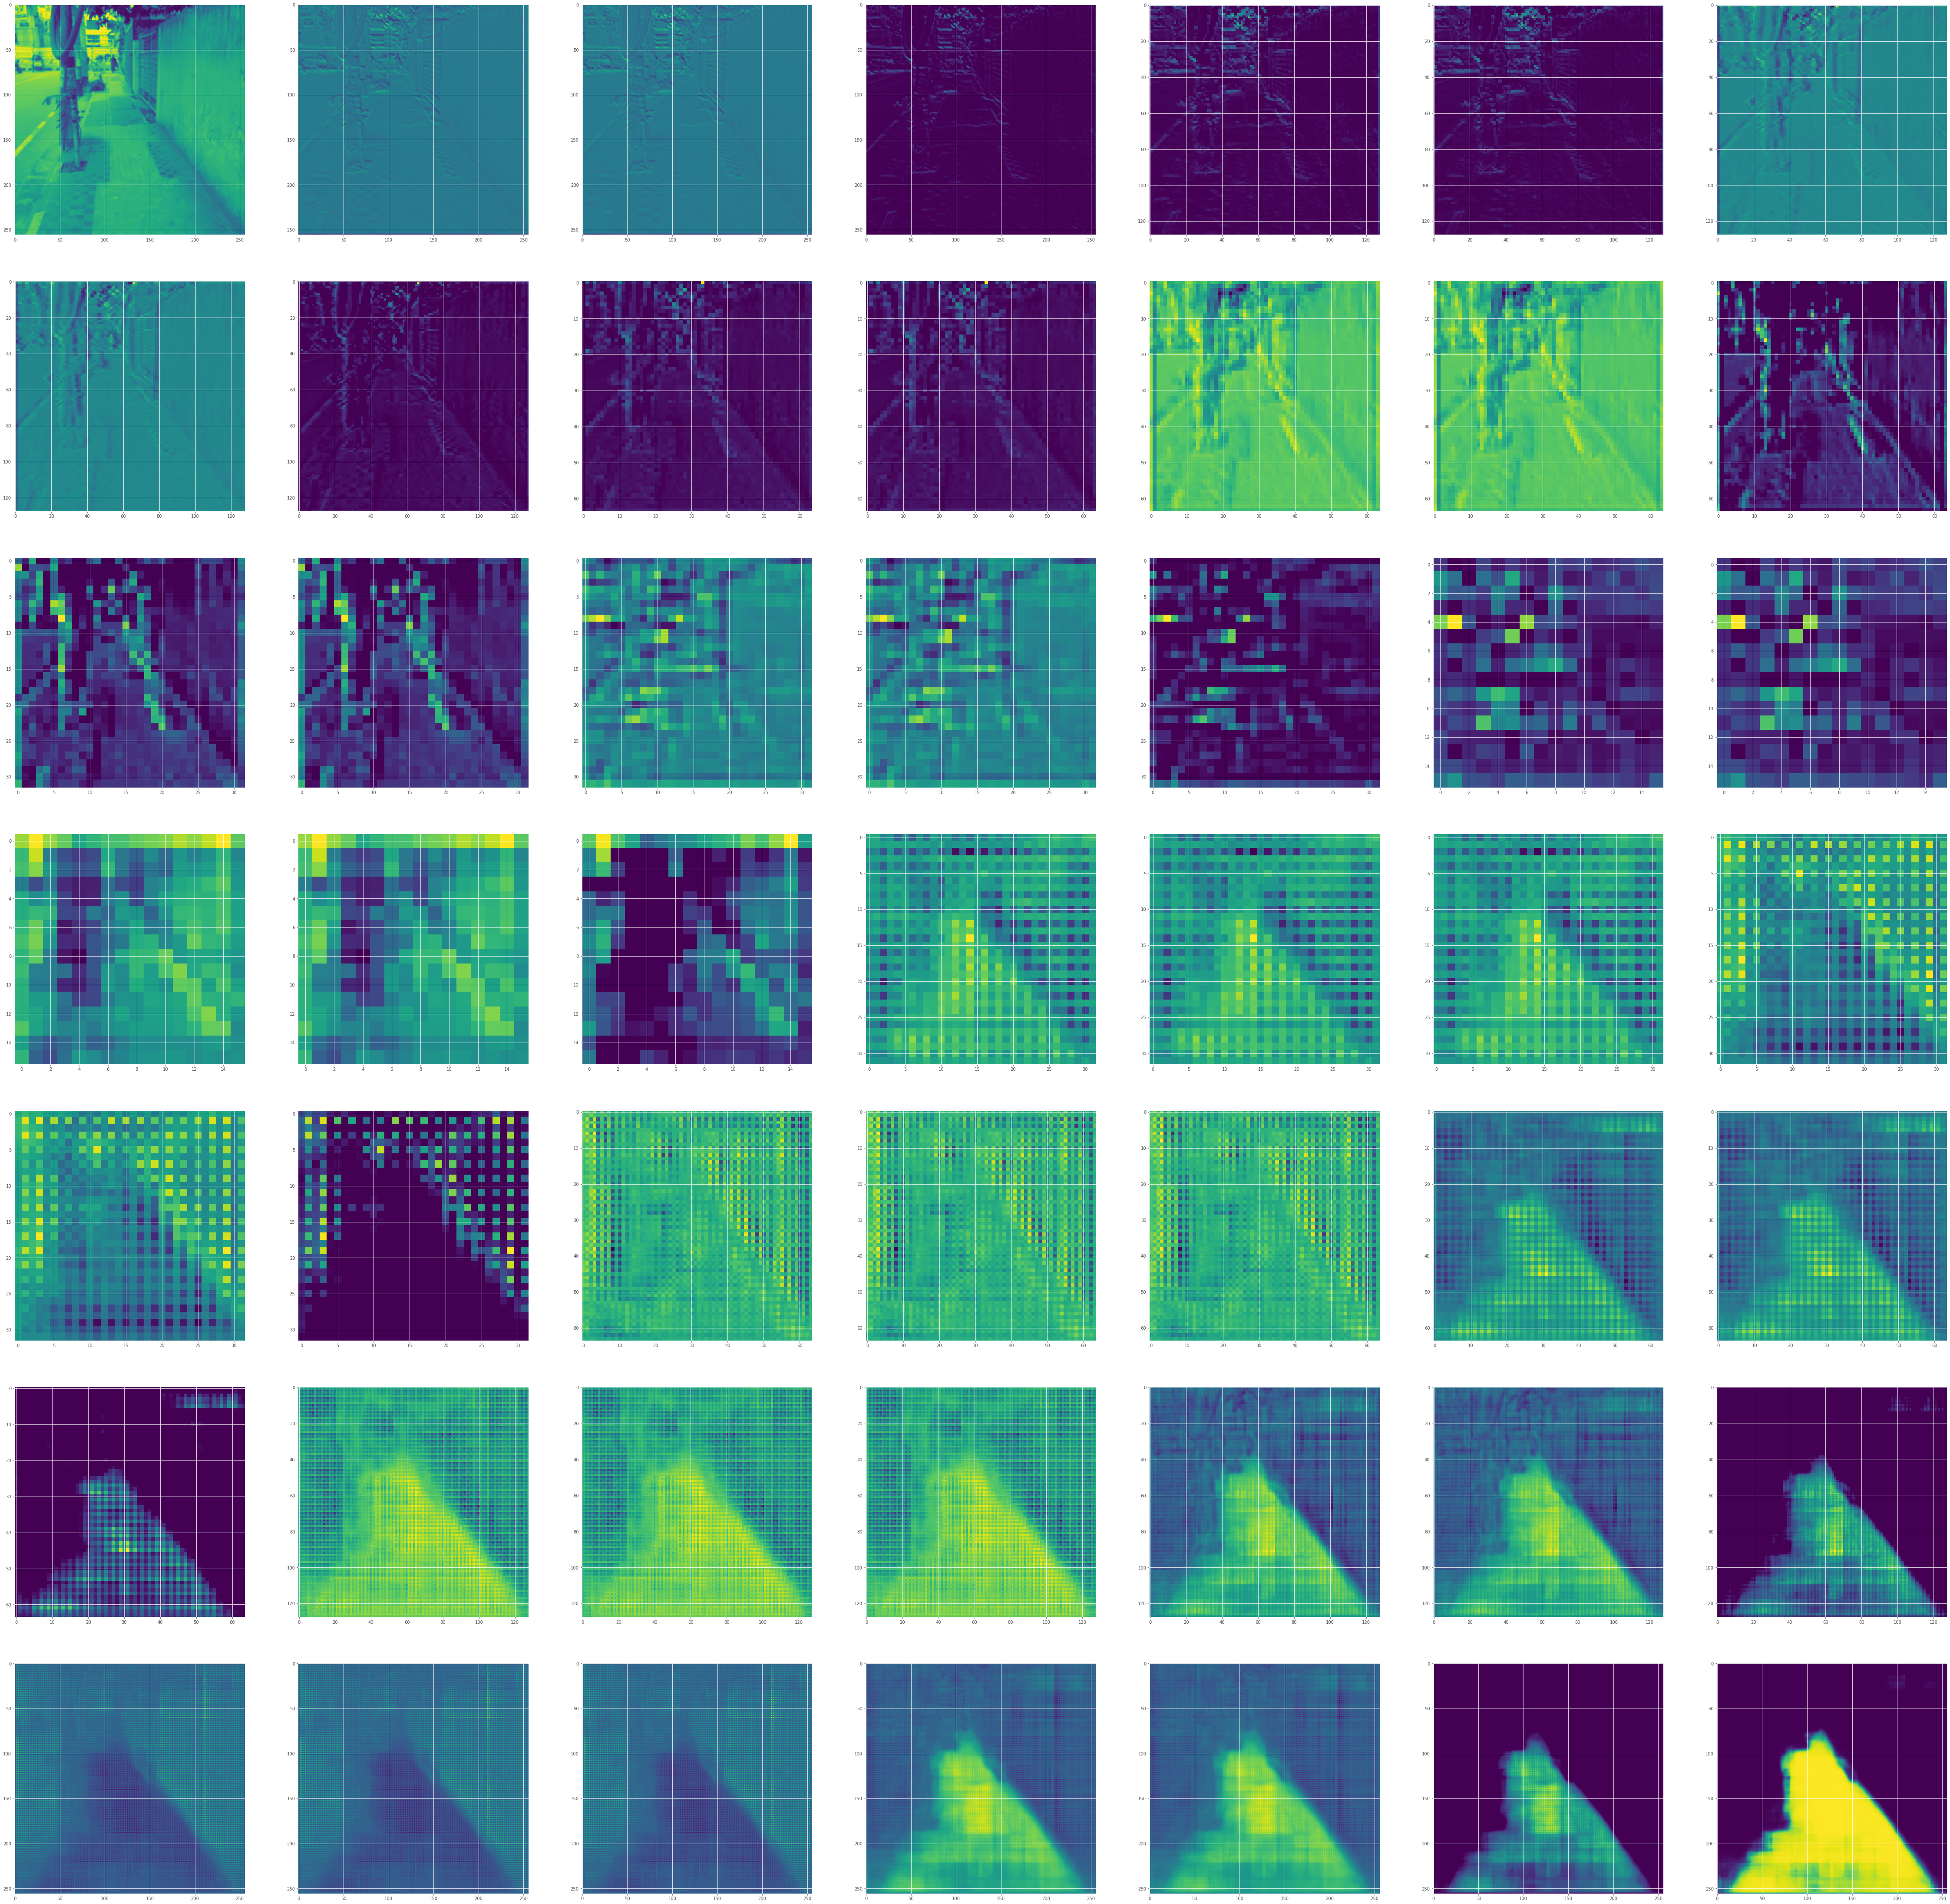

In [29]:
def get_nth_layer_output(n):
    nth_layer_output = K.backend.function([model.layers[0].input],
                                    [model.layers[n].output])
    return nth_layer_output

fig, axs = plt.subplots(7, 7, figsize=(80, 80))
axs[0][0].imshow(X_valid[8].reshape(256, 256), cmap='viridis')
row = 0
col = 1
for n in range(1, len(model.layers)):
    if col == 7:
        row += 1
        col = 0
    nth_out = get_nth_layer_output(n)
    nth_out = nth_out(X_valid[8].reshape((1, 256, 256, 1)))[0] 
    axs[row][col].imshow(nth_out[0,:,:,0], cmap='viridis')
    col += 1

## References
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [zhixuhao](https://github.com/zhixuhao/unet)